In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
np.random.seed(42)

In [2]:
data = pd.read_csv('E:/Machine Learning Projects/Skin Cancer Classification/HAM10000_metadata.csv')

SIZE = 64

In [3]:
le = LabelEncoder()
le.fit(data['dx'])
LabelEncoder()
data['label'] = le.transform(data["dx"])

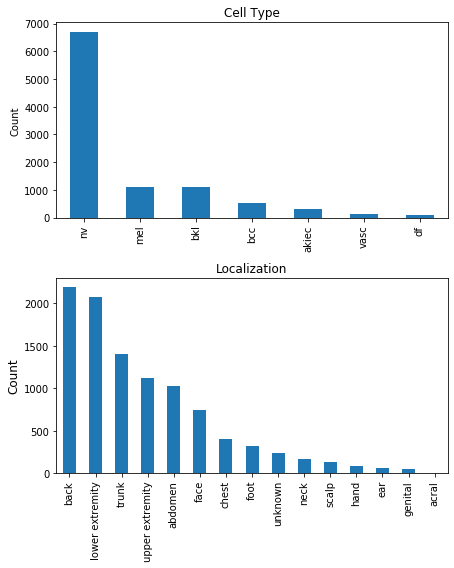

In [4]:
#Plot data frequency

fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(221)
data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(223)
data['localization'].value_counts().plot(kind='bar')
ax2.set_ylabel('Count', size=12)
ax2.set_title('Localization')

plt.tight_layout()
plt.show()

In [5]:
# Balanced the data set
df_0 = data[data['label'] == 0]
df_1 = data[data['label'] == 1]
df_2 = data[data['label'] == 2]
df_3 = data[data['label'] == 3]
df_4 = data[data['label'] == 4]
df_5 = data[data['label'] == 5]
df_6 = data[data['label'] == 6]

n_samples = 777
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

data_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [6]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('./', '*', '*.jpg'))}

data_balanced['path'] = data['image_id'].map(image_path.get)
data_balanced['image'] = data_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

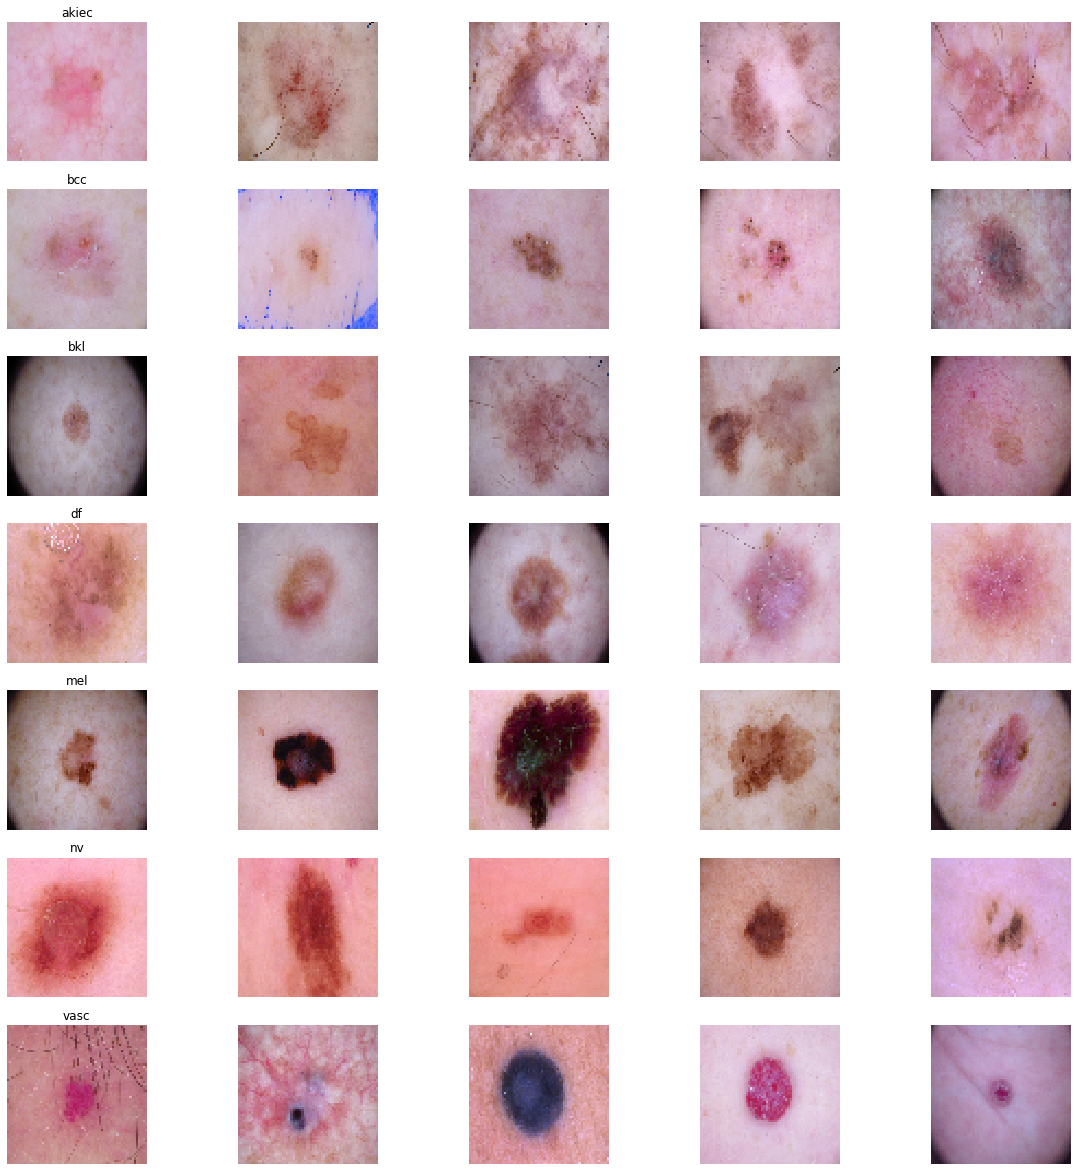

In [7]:
n_samples = 5
# Plot the images
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         data_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [8]:
X = np.asarray(data_balanced['image'].tolist())
X = X / 255.  # Normalize
Y = data_balanced['label']
Y_cat = to_categorical(Y, num_classes=7)  # Convert to categorical

# Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [10]:
# CNN Model
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        7

In [12]:
batch_size = 16
epochs = 25

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/25
255/255 - 44s - loss: 1.4511 - acc: 0.4165 - val_loss: 1.4517 - val_acc: 0.3956
Epoch 2/25
255/255 - 44s - loss: 1.3538 - acc: 0.4670 - val_loss: 1.4325 - val_acc: 0.4074
Epoch 3/25
255/255 - 44s - loss: 1.2988 - acc: 0.4884 - val_loss: 1.2558 - val_acc: 0.5309
Epoch 4/25
255/255 - 44s - loss: 1.1932 - acc: 0.5374 - val_loss: 1.2517 - val_acc: 0.5169
Epoch 5/25
255/255 - 44s - loss: 1.1224 - acc: 0.5636 - val_loss: 1.1951 - val_acc: 0.5654
Epoch 6/25
255/255 - 44s - loss: 1.0739 - acc: 0.5854 - val_loss: 1.0594 - val_acc: 0.6015
Epoch 7/25
255/255 - 44s - loss: 0.9955 - acc: 0.6328 - val_loss: 1.0353 - val_acc: 0.6088
Epoch 8/25
255/255 - 44s - loss: 0.9636 - acc: 0.6406 - val_loss: 1.0108 - val_acc: 0.6103
Epoch 9/25
255/255 - 44s - loss: 0.9179 - acc: 0.6484 - val_loss: 0.9412 - val_acc: 0.6485
Epoch 10/25
255/255 - 44s - loss: 0.8775 - acc: 0.6725 - val_loss: 1.0177 - val_acc: 0.6147
Epoch 11/25
255/255 - 44s - loss: 0.8723 - acc: 0.6764 - val_loss: 0.9151 - val_acc: 0.67

In [13]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

43/43 [==============================] - 3s 69ms/step - loss: 0.7788 - acc: 0.7368
Test accuracy: 0.7367647290229797


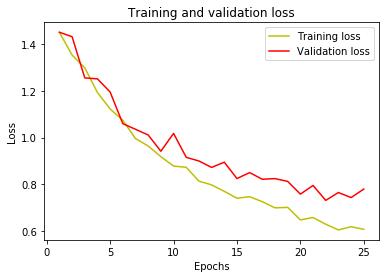

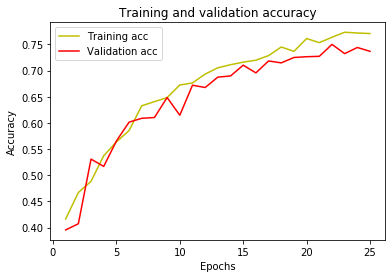

In [14]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis=1)

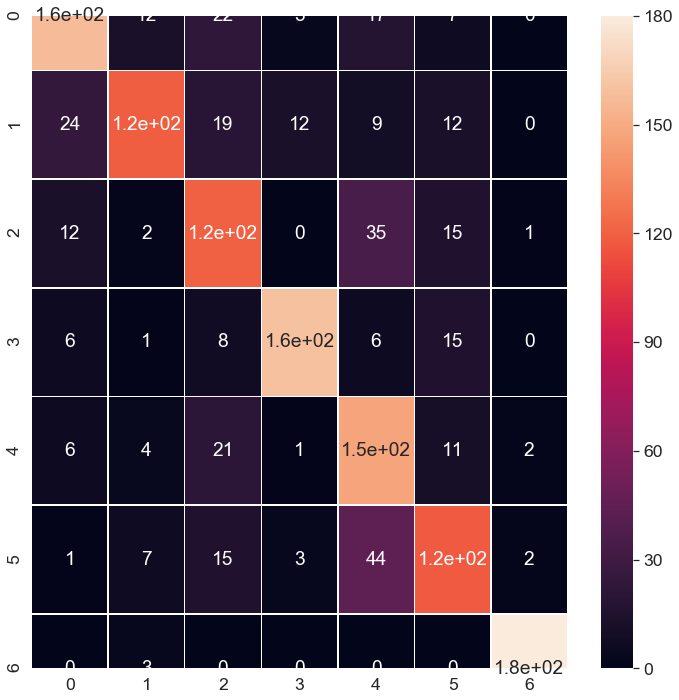

In [23]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)